The Basic Pipeline is :Download video,extract frames,encode in feature vectors,index based on cosine similarity using hnsw,query the index ,reconstruct video path with ID ,showcase the video

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Code for downloading videos

In [ ]:
import pandas as pd
from pytube import YouTube

# Read the CSV file
video_df = pd.read_csv('/content/drive/MyDrive/Clip_Search/video_subset.csv')

# Define the output directory for the downloaded videos
output_dir = '/content/drive/MyDrive/Clip_Search/videos'

# Iterate over the rows of the DataFrame
for index, row in video_df.iterrows():
    # Get the YouTube video URL from the second column of the CSV file
    url = row[1]
    try:
        # Create a YouTube object for the video
        yt = YouTube(url)

        # Get the highest resolution stream
        stream = yt.streams.get_highest_resolution()

        # Define the output file path
        output_path = output_dir +'/'+ row[0] + '.mp4'

        # Download the video
        stream.download(output_path)

        print(f"{row[0]} downloaded successfully.")

    except Exception as e:
        print(f"{row[0]} could not be downloaded. Error: {str(e)}")


Weekend in North Goa 🌊 GOA TRAVEL VLOG | Kritika Goel downloaded successfully.
Jathar Textile Pvt Ltd Ichalkaranji downloaded successfully.
Paddleboarding on the North Shore of Oahu, Hawaii downloaded successfully.
Common - The Food downloaded successfully.
Wayanad Pooppoli 2018 - വയനാട് പൂപ്പൊലി 2018 downloaded successfully.
What If You Only Drank Soda? downloaded successfully.
Tom Insel - Science and Technology: New Frontiers for Helping People with Mental Illness. downloaded successfully.
Bebe Rexha - Meant to Be (feat. Florida Georgia Line) [Official Music Video] downloaded successfully.
ആദ്യ യൂട്യൂബ്  ലൈവ് downloaded successfully.
How To Plan a Trip to Goa In Budget | Tips and Suggestions for Goa Holiday 2017 India downloaded successfully.
Congress & BJP Spar Over Credit For Ak-203 Factory In Amethi | CNN-News18 could not be downloaded. Error: IgbV2x2F9uU is a private video
Delicious CHEAP EATS in Singapore | Maxwell Hawker downloaded successfully.
Formalloy Laser Metal Deposition

KeyboardInterrupt: ignored

Code for extracting frames

In [ ]:
import cv2
import os
import glob
import concurrent.futures

def extract_frames(video_path, save_path, fps):
    vidcap = cv2.VideoCapture(video_path)
    success, image = vidcap.read()
    count = 0
    while success:
        if count % fps == 0:
            cv2.imwrite(os.path.join(save_path, 'frame{:04d}.jpg'.format(count)), image)
        success, image = vidcap.read()
        count += 1

def process_video(video_dir):
    video_file = glob.glob(os.path.join(video_dir, '*.mp4'))[0]
    save_dir = os.path.join(video_dir, 'frames')
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    try:
        fps = int(cv2.VideoCapture(video_file).get(cv2.CAP_PROP_FPS))
        extract_frames(video_file, save_dir, fps)
        print(f'{video_file} done')
    except Exception as e:
        print(f'{video_file} failed: {e}')

if __name__ == '__main__':
    videos_dir = '/content/drive/MyDrive/Clip_Search/videos'
    video_dirs = [os.path.join(videos_dir, d) for d in os.listdir(videos_dir) if os.path.isdir(os.path.join(videos_dir, d))]
    
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = [executor.submit(process_video, dir) for dir in video_dirs]
        for future in concurrent.futures.as_completed(futures):
            pass



/content/drive/MyDrive/Clip_Search/videos/What If You Only Drank Soda?.mp4/What If You Only Drank Soda.mp4 done
/content/drive/MyDrive/Clip_Search/videos/Paddleboarding on the North Shore of Oahu, Hawaii.mp4/Paddleboarding on the North Shore of Oahu Hawaii.mp4 done
/content/drive/MyDrive/Clip_Search/videos/How To Plan a Trip to Goa In Budget | Tips and Suggestions for Goa Holiday 2017 India.mp4/How To Plan a Trip to Goa In Budget  Tips and Suggestions for Goa Holiday 2017 India.mp4 done
/content/drive/MyDrive/Clip_Search/videos/Samsung Display showcase manufacturing Process of AMOLED.mp4/Samsung Display showcase manufacturing Process of AMOLED.mp4 done
/content/drive/MyDrive/Clip_Search/videos/Weekend in North Goa 🌊 GOA TRAVEL VLOG | Kritika Goel.mp4/Weekend in North Goa 🌊 GOA TRAVEL VLOG  Kritika Goel.mp4 done
/content/drive/MyDrive/Clip_Search/videos/This Theory Suggests Our Perspective of Galaxies Could Be Wrong.mp4/This Theory Suggests Our Perspective of Galaxies Could Be Wrong.mp4

Encoding frames

In [ ]:
import torch
import clip
import os
import cv2
from PIL import Image
from torchvision import transforms

# Load the CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device=device)

# Define the path to the directory containing the videos
videos_path = '/content/drive/MyDrive/Clip_Search/videos'

# Define the transform to be applied to each image
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    preprocess
])

# Loop through each subdirectory in the videos directory
for subdir in os.listdir(videos_path):
    subdir_path = os.path.join(videos_path, subdir)
    # Check if the subdirectory is itself a directory
    if os.path.isdir(subdir_path):
        frames_path = os.path.join(subdir_path, 'frames')
        # Check if the "frames" directory exists and is not empty
        if os.path.exists(frames_path) and os.path.isdir(frames_path) and os.listdir(frames_path):
            # Create a new directory for the encoded images
            encoded_path = os.path.join(subdir_path, 'encoded')
            os.makedirs(encoded_path, exist_ok=True)
            print(f"Encoding frames for video {subdir}...")
            # Loop through each image in the "frames" directory
            for image_file in os.listdir(frames_path):
                image_path = os.path.join(frames_path, image_file)
                # Check if the file is actually an image and not another directory
                if os.path.isfile(image_path) and image_path.endswith('.jpg'):
                    # Open the image file and apply the transform
                    with open(image_path, 'rb') as f:
                        image = Image.open(f).convert('RGB')
                    image = transform(image).unsqueeze(0).to(device)
                    # Encode the image using the CLIP model
                    with torch.no_grad():
                        features = model.encode_image(image).cpu().numpy()
                    # Save the encoded features as a numpy file
                    np.save(os.path.join(encoded_path, f'{image_file}.npy'), features)
            print(f"Finished encoding frames for video {subdir}.")


Encoding frames for video Weekend in North Goa 🌊 GOA TRAVEL VLOG | Kritika Goel.mp4...
Finished encoding frames for video Weekend in North Goa 🌊 GOA TRAVEL VLOG | Kritika Goel.mp4.
Encoding frames for video Paddleboarding on the North Shore of Oahu, Hawaii.mp4...
Finished encoding frames for video Paddleboarding on the North Shore of Oahu, Hawaii.mp4.
Encoding frames for video Wayanad Pooppoli 2018 - വയനാട് പൂപ്പൊലി 2018.mp4...
Finished encoding frames for video Wayanad Pooppoli 2018 - വയനാട് പൂപ്പൊലി 2018.mp4.
Encoding frames for video What If You Only Drank Soda?.mp4...
Finished encoding frames for video What If You Only Drank Soda?.mp4.
Encoding frames for video Tom Insel - Science and Technology: New Frontiers for Helping People with Mental Illness..mp4...
Finished encoding frames for video Tom Insel - Science and Technology: New Frontiers for Helping People with Mental Illness..mp4.
Encoding frames for video Bebe Rexha - Meant to Be (feat. Florida Georgia Line) [Official Music V

In [6]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-l56k23n2
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-l56k23n2
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369398 sha256=d83ae3c04247ffa8ba2f883b95f6345e070bd60ec0a6b423a83d44e838b6624b
  Stored in directory: /tmp/pip-ephem-wheel-cache-tx3d4w3c/wheels/c8/e4/e1/11374c111387672fc2068dfbe0d4b424cb9cdd1b2e184a71b5
Successfully built clip


In [7]:
!pip install nmslib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 56.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 18.9 MB/s eta 0:00:00


Indexing the Encoded feature vectors

In [35]:
#code for indexing
import os
import numpy as np
import nmslib

# Define the path to the directory containing the videos
videos_path = '/content/drive/MyDrive/Clip_Search/videos'
index_path = '/content/drive/MyDrive/Clip_Search/nmslib_index'
id_map_file = '/content/drive/MyDrive/Clip_Search/nmslib_id_map'

# Set up the index
d = 512  # dimension of the feature vectors
index = nmslib.init(method='hnsw', space='cosinesimil')
index.addDataPointBatch(np.zeros((1, d)))  # add a dummy point to allocate memory

# Setting up mapping for location to ids
id_map = {}
count = 0

# Loop through each subdirectory in the videos directory
for subdir in os.listdir(videos_path):
    subdir_path = os.path.join(videos_path, subdir)
    # Check if the subdirectory is itself a directory
    if os.path.isdir(subdir_path):
        encoded_path = os.path.join(subdir_path, 'encoded')
        # Check if the "encoded" directory exists and is not empty
        if os.path.exists(encoded_path) and os.path.isdir(encoded_path) and os.listdir(encoded_path):
            print(f"Indexing frames for video {subdir}...")
            # Loop through each encoded frame in the "encoded" directory
            for frame_file in os.listdir(encoded_path):
                frame_path = os.path.join(encoded_path, frame_file)
                # Check if the file is actually an encoded frame and not another directory
                if os.path.isfile(frame_path) and frame_path.endswith('.npy'):
                    # Load the encoded features from the numpy file
                    features = np.load(frame_path)
                    features = features.astype('float32')
                    # Add the features to the index, using the video ID and frame ID as metadata
                    frame_id = subdir + '_' + os.path.splitext(frame_file)[0]
                    id_map[count] = frame_id
                    index.addDataPoint(count, features)
                    count += 1

            print(f"Finished indexing frames for video {subdir}.")

# Set index parameters
index_param = {
    'M': 16,  # number of neighbors to visit for HNSW construction
    'indexThreadQty': 4,  # number of threads to use for index construction
    'efConstruction': 100,  # size of dynamic list for HNSW construction
    'post': 0  # disable postprocessing (for faster indexing)
}
# Create the index
index.createIndex(index_param, print_progress=True)

# Save the index and id map
index.saveIndex(index_path)
np.save(id_map_file, id_map)


Indexing frames for video Weekend in North Goa 🌊 GOA TRAVEL VLOG | Kritika Goel.mp4...
Finished indexing frames for video Weekend in North Goa 🌊 GOA TRAVEL VLOG | Kritika Goel.mp4.
Indexing frames for video Paddleboarding on the North Shore of Oahu, Hawaii.mp4...
Finished indexing frames for video Paddleboarding on the North Shore of Oahu, Hawaii.mp4.
Indexing frames for video Wayanad Pooppoli 2018 - വയനാട് പൂപ്പൊലി 2018.mp4...
Finished indexing frames for video Wayanad Pooppoli 2018 - വയനാട് പൂപ്പൊലി 2018.mp4.
Indexing frames for video What If You Only Drank Soda?.mp4...
Finished indexing frames for video What If You Only Drank Soda?.mp4.
Indexing frames for video Tom Insel - Science and Technology: New Frontiers for Helping People with Mental Illness..mp4...
Finished indexing frames for video Tom Insel - Science and Technology: New Frontiers for Helping People with Mental Illness..mp4.
Indexing frames for video Bebe Rexha - Meant to Be (feat. Florida Georgia Line) [Official Music V

Querying these indexed frames
This returns video list and frames in the order respectively

In [8]:
import clip
import torch
def encode_query_text(query):
 device = 'cuda' if torch.cuda.is_available() else 'cpu'
 model, preprocess = clip.load('ViT-B/32', device=device)
 text = clip.tokenize(query).to(device)
 with torch.no_grad():
    
     query_vector = model.encode_text(text).cpu().numpy().flatten()
 return query_vector

In [17]:
import os
import nmslib
import numpy as np

# Define the path to the directory containing the videos
def search(query):
   video_file=[]
   videos_path = '/content/drive/MyDrive/Clip_Search/videos'
   index_path = '/content/drive/MyDrive/Clip_Search/nmslib_index'
   id_map_file = '/content/drive/MyDrive/Clip_Search/nmslib_id_map.npy'

# Load the feature vectors index and ID mapping
   index = nmslib.init(method='hnsw', space='cosinesimil')
   index.loadIndex(index_path)
   id_map = np.load(id_map_file, allow_pickle=True).item()

# Define a query vector (for example, using OpenAI's CLIP)
   query_vector = encode_query_text(query)  # your code here

# Query the index with the query vector
   k = 100  # number of nearest neighbors to retrieve
   neigh_ind,neigh_dist = index.knnQuery(query_vector, k=k)
   image_paths=[]
   
   freq={}
# Retrieve the video and frame paths corresponding to the nearest neighbors
   for i in range(k):
       frame_id = id_map[neigh_ind[i]]
       video_id, frame_num = frame_id.split('_')
       if video_id not in  freq:
         freq[video_id]=1
         video_file.append(video_id)
         
         frame_path = os.path.join(videos_path, video_id, 'frames', frame_num)
         image_paths.append(frame_path)
   
   return video_file,image_paths


Code for creating a api using flask 

In [52]:
import clip
import torch
def encode_query_text(query):
 device = 'cuda' if torch.cuda.is_available() else 'cpu'
 model, preprocess = clip.load('ViT-B/32', device=device)
 text = clip.tokenize(query).to(device)
 with torch.no_grad():
    
     query_vector = model.encode_text(text).cpu().numpy().flatten()
 return query_vector

 import os
import nmslib
import numpy as np

from flask import Flask, request, jsonify
from flask_ngrok import run_with_ngrok
app = Flask(__name__)
run_with_ngrok(app)   

@app.route('/search', methods=['POST'])
def search():
    # Get the query vector from the request
    query = request.get_json()['query']
    videos_path = '/content/drive/MyDrive/Clip_Search/videos'
    index_path = '/content/drive/MyDrive/Clip_Search/nmslib_index'
    id_map_file = '/content/drive/MyDrive/Clip_Search/nmslib_id_map.npy'

# Load the feature vectors index and ID mapping
    index = nmslib.init(method='hnsw', space='cosinesimil')
    index.loadIndex(index_path)
    id_map = np.load(id_map_file, allow_pickle=True).item()

# Define a query vector (for example, using OpenAI's CLIP)
    query_vector = encode_query_text(query)  # your code here

# Query the index with the query vector
    k = 100  # number of nearest neighbors to retrieve
    neigh_ind,neigh_dist = index.knnQuery(query_vector, k=k)

    freq={}
    video_tags = ''
# Retrieve the video and frame paths corresponding to the nearest neighbors
    for i in range(k):
       frame_id = id_map[neigh_ind[i]]
       video_id, frame_num = frame_id.split('_')
       if video_id not in  freq:
         freq[video_id]=1
         video_tags += f'<li><video src="{os.path.join(videos_path,video_id,video_id)}" controls></video></li>'


        

    # create an HTML page with the list of videos
    html = f'''
    <html>
        <body>
            <h1>Search Results for "{query}"</h1>
            <ul>{video_tags}</ul>
        </body>
    </html>
    '''

    return html


In [51]:
!pip install flask-ngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [54]:
if __name__ == '__main__':
   app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


 * Running on http://67d5-34-75-120-167.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


INFO:werkzeug:127.0.0.1 - - [16/Apr/2023 12:11:40] "GET / HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [16/Apr/2023 12:11:41] "GET /favicon.ico HTTP/1.1" 404 -


Showing the working in the notebook 

In [20]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# list of image file paths
def clip_search(query):
  video_list,image_paths = search(query)
# loop through the image paths and load each image as a numpy array
  images = []
  for path in image_paths:
      image = Image.open(path)
      image_np = np.array(image)
      images.append(image_np)

# plot the images in a grid
  fig, axes = plt.subplots(nrows=1, ncols=len(images), figsize=(20, 10))
  for i, image in enumerate(images):
      print(video_list[i])
      axes[i].imshow(image)
      axes[i].axis('off')
  plt.show()


girl and a boy in a car
AMBRAI GHAT PE WAAT! | FVRxpress.mp4
MI PRIMER DÍA EN LA INDIA! | Alex Tienda Ft. Yellow Mellow.mp4
A Normal Day in Dubai ....mp4
Iggy Azalea - Fancy ft. Charli XCX (Official Music Video).mp4
Austria Roadtrip | Travel Monkey Blog.mp4
A 'MUST WATCH' GOA VLOG | 21st BIRTHDAY IN GOA | PART 1 : NORTH GOA.mp4
Abhayaranyam Guest House - Stay in Mudumalai Tiger Reserve inside Forest.mp4
| Road trip | EDA Video Blog |.mp4
മുഴുപ്പിലങ്ങാട് ബീച്ച് (കണ്ണൂർ) Muzhuppilangad Drive-in Beach, Kannur Vlog #425.mp4
SOUTH KOREA, BUSAN TRAVEL GUIDE.mp4


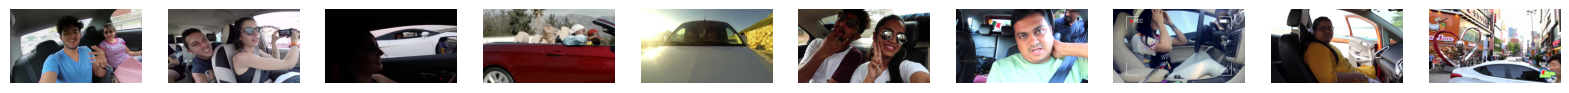

In [25]:
query=input()
clip_search(query)